<a href="https://colab.research.google.com/github/eyalgur1/Computer_Vision/blob/main/4_corner_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# LaTeX and Google Drive configuration

!sudo apt-get update
!sudo apt-get install -y texlive texlive-latex-extra dvipng texlive-fonts-recommended cm-super


plt.rcParams.update({
    "text.usetex": True,             # Use LaTeX for all text
    "font.family": "serif",          # Use serif fonts
    "font.serif": ["Computer Modern Roman"],  # Use Computer Modern Roman font
    "text.latex.preamble": r"\usepackage{amsmath}",  # Load additional packages
    "font.size": 16,                 # Default font size
    "axes.titlesize": 16,            # Title font size
    "axes.labelsize": 16,            # Axis labels font size
    "xtick.labelsize": 10,           # X-tick labels font size
    "ytick.labelsize": 10,           # Y-tick labels font size
    "legend.fontsize": 14            # Legend font size
})

from google.colab import drive
drive.mount("/content/drive/")

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,226 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,517 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/restrict

## **Gradient of a Corner**

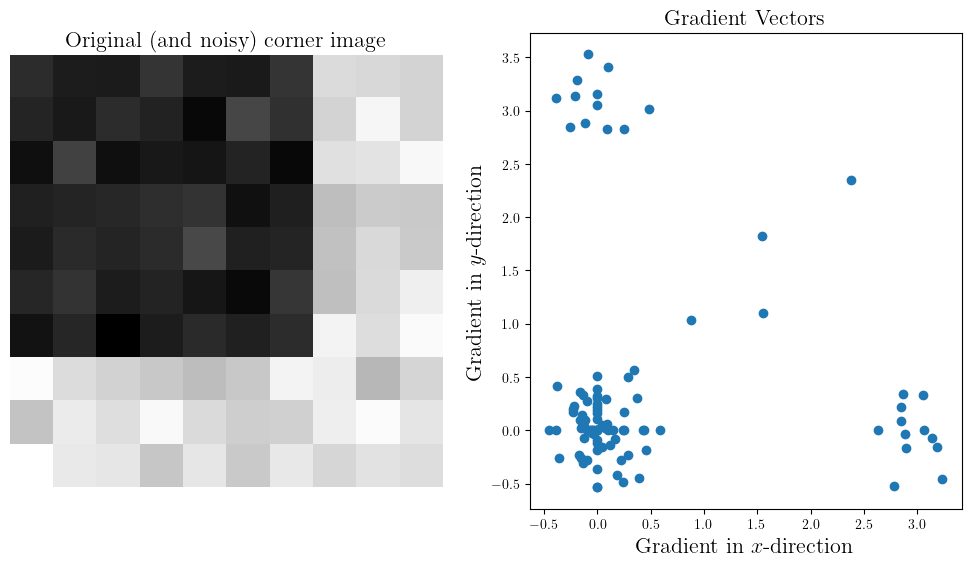

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the image
image = np.hstack((np.vstack((np.zeros((7,7)), np.ones((3,7)))), np.vstack((np.ones((7,3)), np.ones((3,3)))))) # for analysis
image = image + np.random.normal(0, 0.1, image.shape)  # add noise to the image

def compute_gradient(image, filter_type='sobel'):
    if filter_type == 'sobel':
        # Sobel filters for x and y directions
        kernel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
        kernel_y = np.transpose(kernel_x)
        grad_x = cv2.filter2D(image, -1, kernel_x)  # -1 will give the output image datatype (64FP etc) as same as the input image
        grad_y = cv2.filter2D(image, -1, kernel_y)
    elif filter_type == 'prewitt':
        # Prewitt filters for x and y directions
        kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
        kernel_y = np.transpose(kernel_x)
        grad_x = cv2.filter2D(image, -1, kernel_x)
        grad_y = cv2.filter2D(image, -1, kernel_y)
    else:
        raise ValueError("Invalid filter type. Use 'sobel' or 'prewitt'.")

    # Calculate gradient magnitude
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

    return grad_x, grad_y, gradient_magnitude

gradx, grady, _ = compute_gradient(image, filter_type='prewitt')

# Plot edges
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original (and noisy) corner image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.scatter(gradx, grady)
plt.axis('scaled')
plt.xlabel('Gradient in $x$-direction')
plt.ylabel('Gradient in $y$-direction')
plt.title('Gradient Vectors')

plt.tight_layout()
plt.show()


## **PCA for Corner Derection**

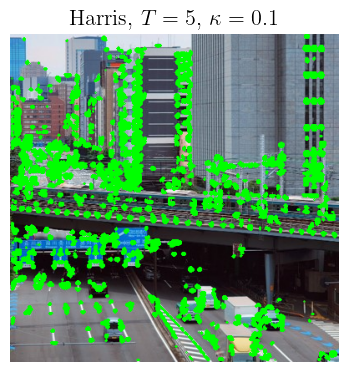

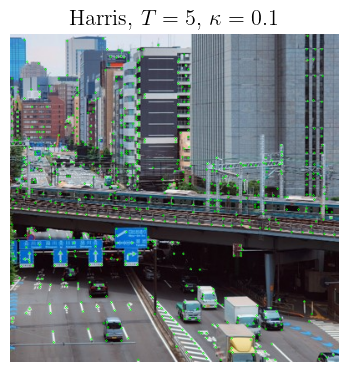

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_gradient(image, filter_type='sobel'):
    if filter_type == 'sobel':
        # Sobel filters for x and y directions
        kernel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
        kernel_y = np.transpose(kernel_x)
        grad_x = cv2.filter2D(image, -1, kernel_x)  # -1 will give the output image datatype (64FP etc) as same as the input image
        grad_y = cv2.filter2D(image, -1, kernel_y)
    elif filter_type == 'prewitt':
        # Prewitt filters for x and y directions
        kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
        kernel_y = np.transpose(kernel_x)
        grad_x = cv2.filter2D(image, -1, kernel_x)
        grad_y = cv2.filter2D(image, -1, kernel_y)
    else:
        raise ValueError("Invalid filter type. Use 'sobel' or 'prewitt'.")

    # Calculate gradient magnitude
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

    return grad_x, grad_y, gradient_magnitude

def corner_detector(image, detector_dict, window_size, edge_detector, non_max_suppression = False):

    # Define the corner detector
    detector = detector_dict['detector']
    threshold = detector_dict['threshold']
    if detector == 'harris':
        kappa = detector_dict['kappa']

    # Compute gradients
    grad_x, grad_y, _ = compute_gradient(image, edge_detector)

    height, width = grad_x.shape
    offset = window_size // 2
    eigenvalue_map = np.zeros((height, width))

    # Iterate over each pixel in the image
    for y in range(offset, height - offset):
        for x in range(offset, width - offset):
            # Extract window_size x window_size window of gradients centered at the pixel (x,y) (truncating the image edges by the offset)
            window_grad_x = grad_x[y - offset:y + offset + 1, x - offset:x + offset + 1].flatten()
            window_grad_y = grad_y[y - offset:y + offset + 1, x - offset:x + offset + 1].flatten()

            # Compute the elements of the covariance matrix
            Ixx = np.sum(window_grad_x * window_grad_x)
            Iyy = np.sum(window_grad_y * window_grad_y)
            Ixy = np.sum(window_grad_x * window_grad_y)

            # Form the covariance matrix
            C = np.array([[Ixx, Ixy], [Ixy, Iyy]])

            # Use the minimum eigenvalue as the corner response
            if detector == 'minimal':
                eigenvalues, _ = np.linalg.eig(C)  # Compute the eigenvalues of the covariance matrix
                eigenvalue_map[y, x] = min(eigenvalues)
            elif detector == 'harris':
                det = C[0,0] * C[1,1] - C[0,1] * C[1,0]
                trace = C[0,0] + C[1,1]
                eigenvalue_map[y, x] = det - kappa*(trace)**2
            elif detector == 'nobel':
                det = C[0,0] * C[1,1] - C[0,1] * C[1,0]
                trace = C[0,0] + C[1,1]
                eigenvalue_map[y, x] = det / (trace + 10**(-7))
            else:
                raise ValueError("Invalid detector type. Use 'minimal', 'harris' or 'nobel'")

    # Threshold the corner response to detect corners
    corners = (eigenvalue_map > threshold)

    if non_max_suppression:
        # Apply non-maximum suppression to refine the corner detection
        suppressed_corners = np.zeros_like(eigenvalue_map)
        for y in range(offset, height - offset):
            for x in range(offset, width - offset):
                if corners[y, x]:
                    # Extract a neighborhood around the current pixel
                    window = eigenvalue_map[y - offset:y + offset + 1, x - offset:x + offset + 1]
                    # If the current pixel has the maximum value in the neighborhood, keep it
                    if eigenvalue_map[y, x] == np.max(window):
                        suppressed_corners[y, x] = True
        corners = suppressed_corners

    return corners


def plot_corner_detection(image_color, image, detector_list, window_size, edge_detector, non_max_suppression = False):
    """
    Function to plot corner detection results for multiple detectors.

    Parameters:
        image_color: Color image for plotting.
        image: Grayscale image for analysis (normalized).
        detector_list: List of dictionaries, each containing detector type and parameters.
        window_size: Size of the window used for corner detection.
        edge_detector: Type of edge detector (e.g., 'sobel', 'prewitt').
    """
    num_detectors = len(detector_list)
    plt.figure(figsize=(8 * max(num_detectors, 1), 4))  # Ensure valid figsize even if there's only one detector
    for idx, detector_dict in enumerate(detector_list):
        # Detect corners
        corners = corner_detector(image, detector_dict, window_size, edge_detector, non_max_suppression)
        corner_points = np.argwhere(corners > 0)

        # Create a copy of the color image to draw corners
        detected_corners = image_color.copy()
        for y, x in corner_points:
            cv2.circle(detected_corners, (x, y), radius=1, color=(0, 255, 0))

        # Plot detected corners
        plt.subplot(1, num_detectors, idx + 1)
        plt.imshow(detected_corners)
        plt.title(f"{detector_dict['detector'].capitalize()}, $T={detector_dict['threshold']}$" + (f", $\kappa={detector_dict['kappa']}$" if 'kappa' in detector_dict else ""))
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Example usage
image_color = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/road.jpg', 1)  # for plotting
image_color = cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB)
image = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/road.jpg', 0) / 255.0  # for analysis

# Set the same hyper-parameters
window_size = 5
edge_detector = 'prewitt'
non_max_suppression = True

# Define the list of detector configurations
minimal_eigenvalue_detectors = [
    {'detector': 'minimal', 'threshold': 0.5},
    {'detector': 'minimal', 'threshold': 10}
]

harris_detectors = [
    {'detector': 'harris', 'threshold': 5, 'kappa': 0.1},
    #{'detector': 'harris', 'threshold': 5, 'kappa': 0.1}
]

nobel_detectors = [
    {'detector': 'nobel', 'threshold': 0.5},
    {'detector': 'nobel', 'threshold': 10}
]

# Plot corner detection for Minimal Eigenvalue Corner Detector
# plot_corner_detection(image_color, image, minimal_eigenvalue_detectors, window_size, edge_detector)

# Plot corner detection for Harris Corner Detector
plot_corner_detection(image_color, image, harris_detectors, window_size, edge_detector)
plot_corner_detection(image_color, image, harris_detectors, window_size, edge_detector, non_max_suppression)

# Plot corner detection for Nobel Corner Detector
# plot_corner_detection(image_color, image, nobel_detectors, window_size, edge_detector)

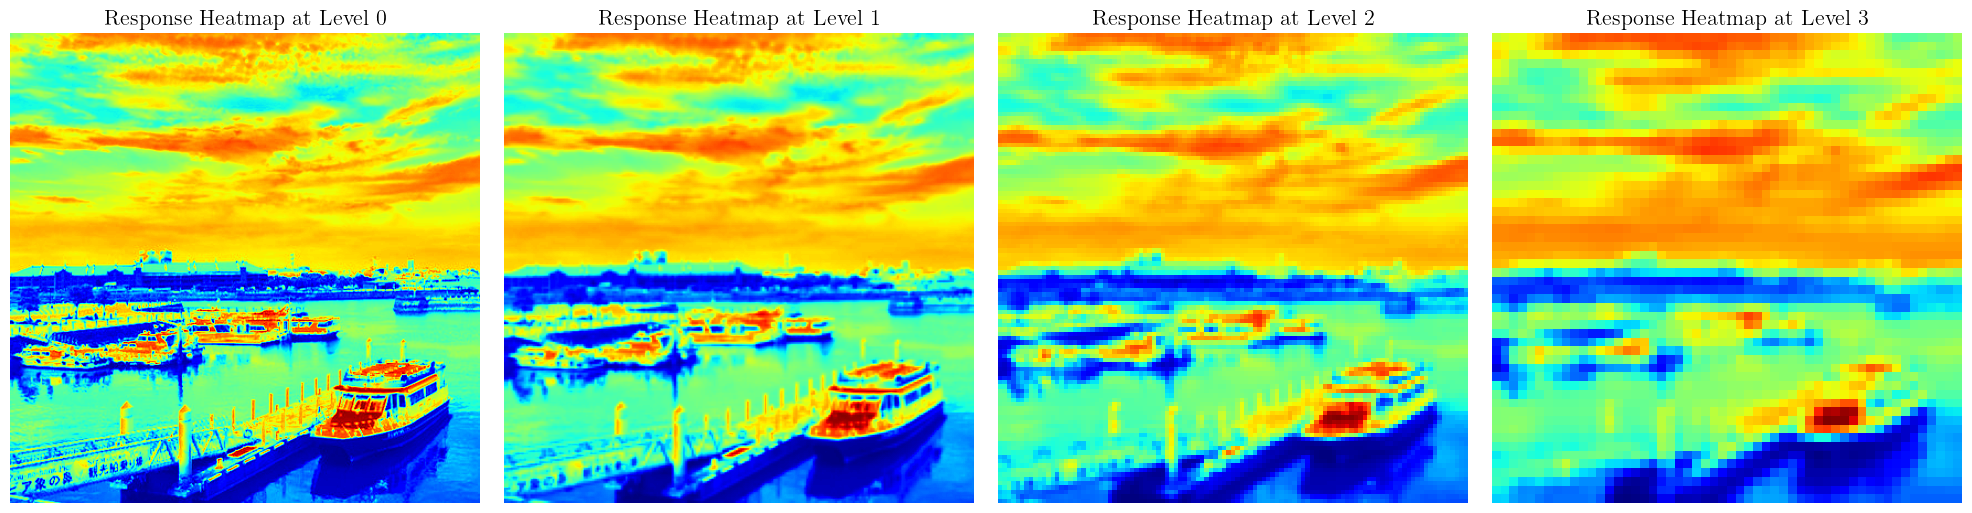

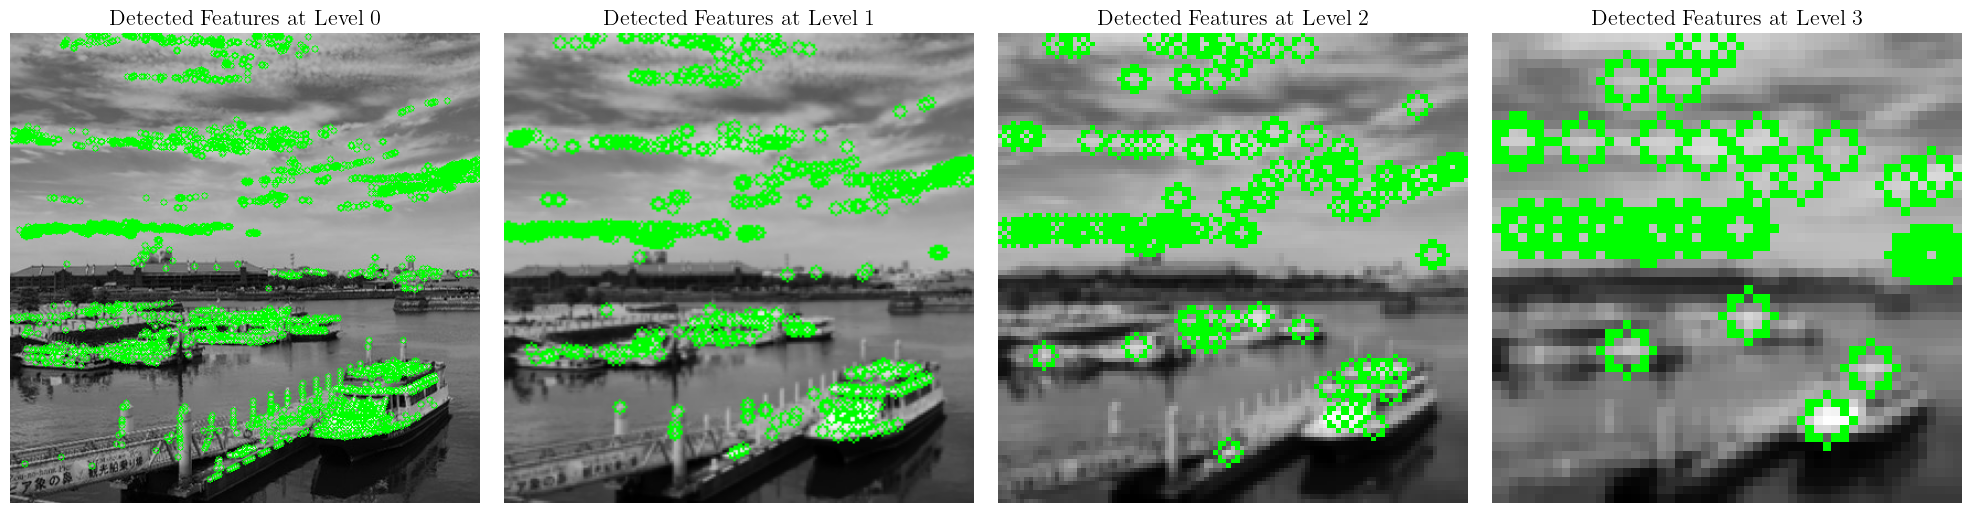

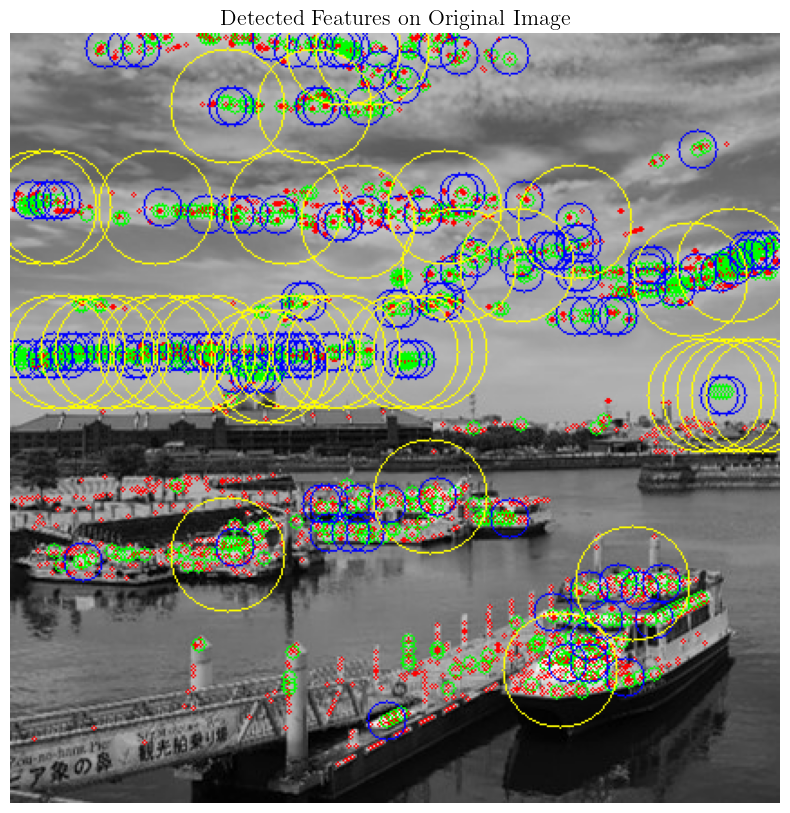

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_laplacian_pyramid(image, num_levels):
    """
    Compute the Laplacian pyramid for a given image.

    Parameters:
        image: Grayscale input image.
        num_levels: Number of levels in the Laplacian pyramid.

    Returns:
        laplacian_pyramid: List of Laplacian pyramid levels.
        variances: List of variances used for each level.
    """
    initial_sigma = 1.0  # (Approximated) initial variance
    variances = [1.0]  # Store varaince at each level
    laplacian_pyramid = [image]
    for i in range(1, num_levels):
        image = cv2.pyrDown(image)
        laplacian_pyramid.append(image)
        variances.append(initial_sigma * (2 ** i))  # Calculate (approximated) sigma for each level
    return laplacian_pyramid, variances

def plot_heatmaps(laplacian_pyramid):
    """
    Plot heatmaps for each level of the Laplacian pyramid.

    Parameters:
        laplacian_pyramid: List of Laplacian pyramid levels.
    """
    num_levels = len(laplacian_pyramid)
    plt.figure(figsize=(20, 10))
    for i in range(num_levels):
        response = laplacian_pyramid[i]
        #norm_response = (response - np.min(response)) / (np.max(response) - np.min(response) + 1e-7)
        plt.subplot(1, num_levels, i + 1)
        plt.imshow(response, cmap='jet')
        plt.title(f'Response Heatmap at Level {i}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def non_maximum_suppression(response, window_size=3, percentile=70, blob_type='bright'):
    """
    Apply non-maximum suppression on the response map.

    Parameters:
        response: 2D numpy array representing the response map.
        window_size: Size of the window for suppression.
        percentile: Percentile to filter responses. Only responses above or below this percentile will be considered as features.
        blob_type: Type of blob to detect ('bright' or 'dark').

    Returns:
        suppressed: 2D numpy array with non-maximum suppression applied.
    """
    if blob_type == 'bright':
        threshold = np.percentile(response, percentile)
    else:
        threshold = np.percentile(response, 100 - percentile)

    suppressed = np.zeros_like(response)
    half_size = window_size // 2

    for y in range(half_size, response.shape[0] - half_size):
        for x in range(half_size, response.shape[1] - half_size):
            window = response[y - half_size:y + half_size + 1, x - half_size:x + half_size + 1]
            if blob_type == 'bright':
                if response[y, x] == np.max(window) and response[y, x] > threshold:
                    suppressed[y, x] = response[y, x]
            elif blob_type == 'dark':
                if response[y, x] == np.min(window) and response[y, x] < threshold:
                    suppressed[y, x] = response[y, x]
    return suppressed

def plot_pyramid_with_detected(laplacian_pyramid, detected_points):
    """
    Plot each level of the Laplacian pyramid with detected pixels highlighted.

    Parameters:
        laplacian_pyramid: List of Laplacian pyramid levels.
        detected_points: List of tuples representing detected features (x, y, level).
    """
    num_levels = len(laplacian_pyramid)
    plt.figure(figsize=(20, 10))
    for i in range(num_levels):
        level_img = laplacian_pyramid[i]
        image_color_level = cv2.cvtColor(((level_img - np.min(level_img)) / (np.max(level_img) - np.min(level_img) + 1e-7) * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
        for (x, y, level) in detected_points:
            if level == i:
                cv2.circle(image_color_level, (x, y), radius=3, color=(0, 255, 0), thickness=1)
        plt.subplot(1, num_levels, i + 1)
        plt.imshow(cv2.cvtColor(image_color_level, cv2.COLOR_BGR2RGB))
        plt.title(f'Detected Features at Level {i}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_detected_features_on_original(image, detected_points, variances, k):
    """
    Plot circles around detected features on the original image, with radius proportional to scale.

    Parameters:
        image: Grayscale input image.
        detected_points: List of tuples representing detected features (x, y, level).
        variances: List of variances for each level.
        k: Scale multiplier between levels.
    """
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    colors_bgr = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (0, 255, 255), (255, 255, 0)]  # Different colors for each scale level in BGR

    for (x, y, level) in detected_points:
        # Upscale the coordinates back to the original image resolution
        scale_factor = 2 ** level
        original_x = int(x * scale_factor)
        original_y = int(y * scale_factor)

        t = variances[level]
        radius = int(np.sqrt(2 * t) * scale_factor)  # Adjusted radius to better reflect the detected scale
        color = colors_bgr[level % len(colors_bgr)]

        # Draw the circle at the correct location on the original image
        cv2.circle(image_color, (original_x, original_y), radius=radius, color=color, thickness=1)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
    plt.title('Detected Features on Original Image')
    plt.axis('off')
    plt.show()

def main():
    # Load image in grayscale
    image_path = '/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/ship.jpg'  # Replace with your path
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image at path {image_path} not found.")

    # Parameters
    num_levels = 4
    initial_sigma = 1.6
    k = np.sqrt(2)

    # Step 1: Calculate Laplacian pyramid
    laplacian_pyramid, variances = compute_laplacian_pyramid(image, num_levels)

    # Step 2 & 3: Calculate responses and plot heatmaps at each level
    plot_heatmaps(laplacian_pyramid)

    # Step 4: Apply non-maximum suppression at each level
    detected_points = []
    for i, response in enumerate(laplacian_pyramid):
        suppressed = non_maximum_suppression(response, percentile=90, blob_type='bright')
        y_coords, x_coords = np.where(suppressed > 0)
        for y, x in zip(y_coords, x_coords):
            detected_points.append((x, y, i))

    # Step 5: Plot the pyramid with detected pixels at each level
    plot_pyramid_with_detected(laplacian_pyramid, detected_points)

    # Step 6: Plot detected features on the original image
    plot_detected_features_on_original(image, detected_points, variances, k)

if __name__ == "__main__":
    main()


## **Harris Blob Detector**

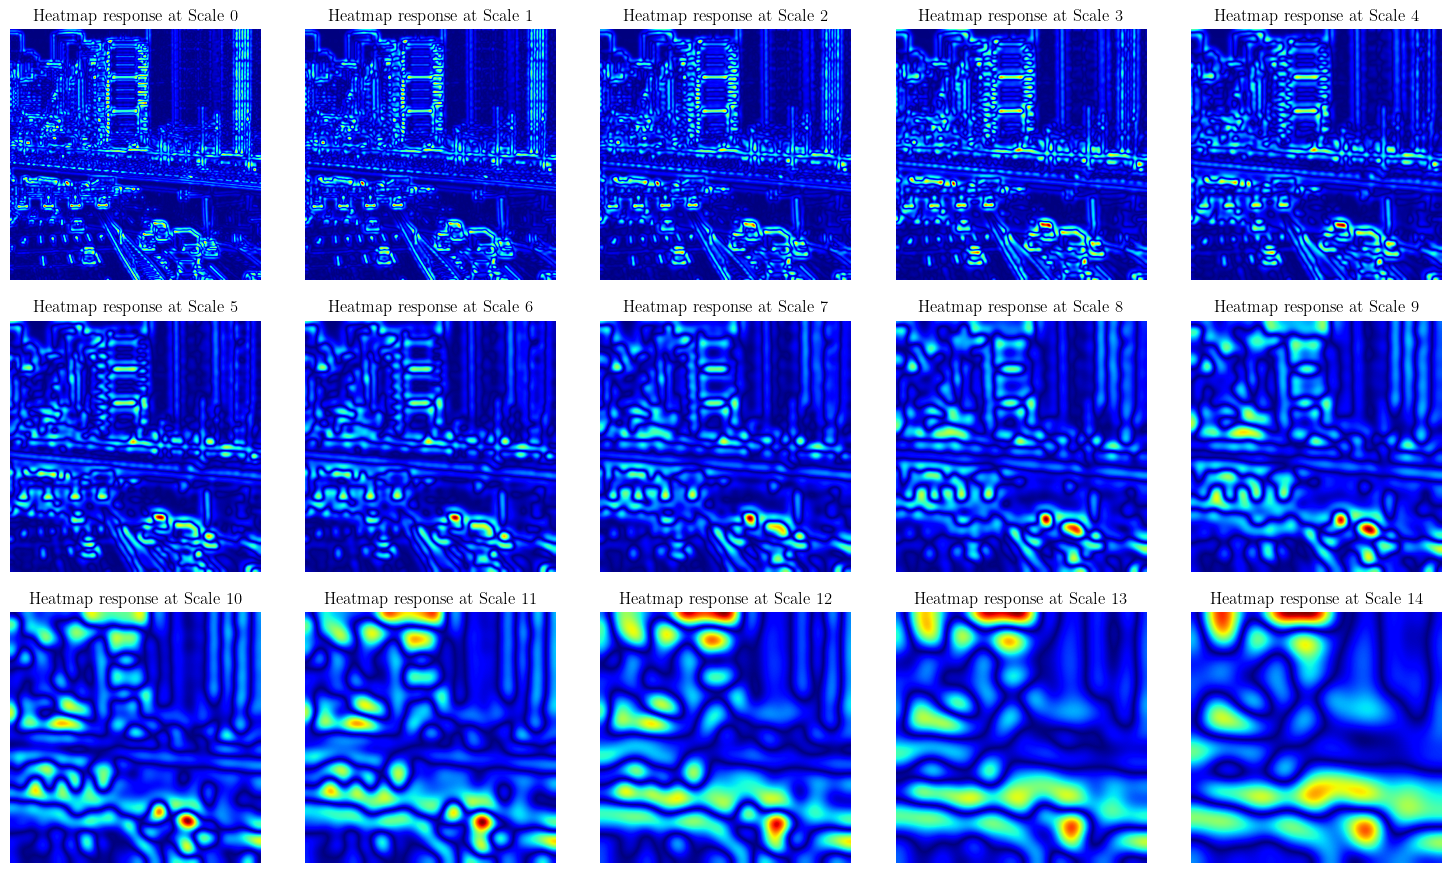

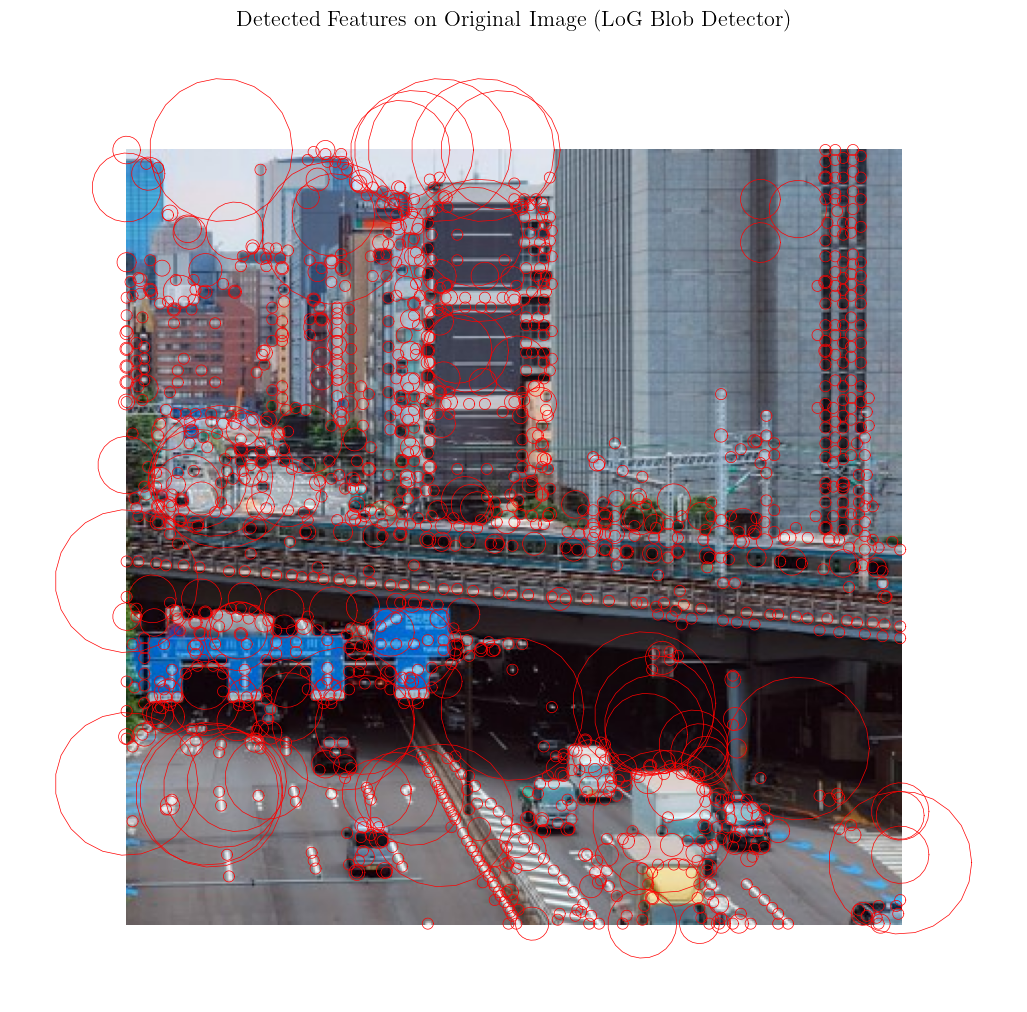

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_laplace, maximum_filter

def detect_blobs_scale_filter(im, threshold=0.005, n=15, initial_sigma=2.0, k=1.2, method='LoG'):
    """
    Detect blobs in an image using either the Laplacian of Gaussian (LoG) filter or the Harris corner response.

    Parameters:
        im (numpy.ndarray): Input image.
        threshold (float): Threshold for blob detection.
        n (int): Number of levels in scale space.
        initial_sigma (float): Initial scale (sigma value).
        k (float): Geometric constant for scaling.
        method (str): Method for detecting blobs, either 'LoG' (Laplacian of Gaussian) or 'Harris'.

    Returns:
        numpy.ndarray: Array of detected blobs, each row representing (x, y, radius, score).
    """
    # Convert the image to grayscale for better processing and normalization
    if len(im.shape) > 2:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        im = im.astype(np.float32) / 255.0  # Normalize to range [0, 1]

    # Generate sigma values for scale-space, starting from the initial sigma and scaling geometrically
    sigma = initial_sigma * k ** np.arange(0, n)
    h, w = im.shape  # Get the dimensions of the image

    # Initialize scale space, which will store the response at each scale level
    scale_space = np.zeros((h, w, n))

    # Smooth the image using a Gaussian kernel to remove corners that are only due to noise
    if method == 'Harris':
        #smoothed = cv2.GaussianBlur(im, (0, 0), sigma[0])
        grad_x = cv2.Sobel(im, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(im, cv2.CV_64F, 0, 1, ksize=3)

        # Calculate Harris matrix components
        Ixx_nominal = grad_x ** 2
        Iyy_nominal = grad_y ** 2
        Ixy_nominal = grad_x * grad_y

    # Loop through each scale level
    for i in range(n):
        if method == 'LoG':  # Laplacian of Gaussian (LoG) method
            # Apply LoG filter, normalized by sigma squared for scale invariance
            L = sigma[i] ** 2 * gaussian_laplace(im, sigma[i])
            # Square the response to emphasize stronger features
            scale_space[:, :, i] = np.abs(L)# ** 2
        elif method == 'Harris':  # Harris corner detection method
            # Smooth the image using a Gaussian kernel at the current scale
            # smoothed = cv2.GaussianBlur(im, (0, 0), sigma[i])

            # # Compute image gradients using Sobel filters
            # grad_x = cv2.Sobel(smoothed, cv2.CV_64F, 1, 0, ksize=3)
            # grad_y = cv2.Sobel(smoothed, cv2.CV_64F, 0, 1, ksize=3)

            # # Calculate Harris matrix components
            # Ixx = grad_x ** 2
            # Iyy = grad_y ** 2
            # Ixy = grad_x * grad_y

            # Apply Gaussian smoothing to Harris matrix components for scaling
            Ixx = cv2.GaussianBlur(Ixx_nominal, (0, 0), sigma[i])
            Iyy = cv2.GaussianBlur(Iyy_nominal, (0, 0), sigma[i])
            Ixy = cv2.GaussianBlur(Ixy_nominal, (0, 0), sigma[i])

            # Compute Harris corner response using determinant and trace of the Harris matrix
            kappa = 0.04  # Empirical constant
            det_M = Ixx * Iyy - Ixy ** 2  # element-wise
            trace_M = Ixx + Iyy
            R = sigma[i] ** 2 * (det_M - kappa * (trace_M ** 2))  # Scale-adapted response

            # Store the response in the scale space
            scale_space[:, :, i] = R
        else:
            raise ValueError("Invalid method. Use 'LoG' or 'Harris'.")

    # Apply 3D non-maximum suppression to find blobs
    blobs = nonmaximum_suppression_3D(scale_space, sigma, threshold)
    return blobs

def nonmaximum_suppression_3D(scale_space, sigma, threshold):
    """
    Perform non-maximum suppression in both spatial and scale dimensions.

    Parameters:
        scale_space (numpy.ndarray): The scale space representation of the image.
        sigma (numpy.ndarray): Array of sigma values used for each scale level.
        threshold (float): Threshold value to filter out weak responses.

    Returns:
        numpy.ndarray: Array of detected blobs, each represented as (x, y, radius, score).
    """
    h, w, n = scale_space.shape

    # Visualize scale space responses as heatmaps (for debugging or visualization purposes)
    plt.figure(figsize=(15, 9))
    for i in range(n):
        plt.subplot(3, int(n/3), i + 1)
        plt.imshow(scale_space[:, :, i], cmap='jet')
        plt.title(f'Heatmap response at Scale {i}', fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Non-maximum suppression across spatial dimensions (3x3 neighborhood)
    nmaxsup = np.zeros((h, w, n))
    for i in range(n):
        nmaxsup[:, :, i] = maximum_filter(scale_space[:, :, i], size=3)

    # Non-maximum suppression across scale dimensions (compare with neighboring scales)
    for i in range(1, n - 1):
        nmaxsup[:, :, i] = np.maximum.reduce([nmaxsup[:, :, i - 1], nmaxsup[:, :, i], nmaxsup[:, :, i + 1]])

    # Retain only local maxima that meet the threshold
    nmaxsup = nmaxsup * (nmaxsup == scale_space)
    blobs = []
    for i in range(n):
        current_level = nmaxsup[:, :, i]
        r, c = np.where(current_level >= threshold)
        for y, x in zip(r, c):
            blobs.append([x, y, sigma[i] * 3/2 if method=='Harris' else sigma[i] * np.sqrt(2), current_level[y, x]])

    blobs = np.array(blobs)
    if blobs.shape[0] < 1000:
        print(f'Number of blobs: {blobs.shape[0]} (< 1000), try a smaller threshold for more detections.')
    return blobs

def draw_blobs(im, blobs, method, nmax=None):
    """
    Draw blobs as circles on the input image.

    Parameters:
        im (numpy.ndarray): Input image (RGB or grayscale).
        blobs (numpy.ndarray): Array of detected blobs, each row is (x, y, radius, score).
        method (str): Method used for blob detection.
        nmax (int, optional): Maximum number of blobs to draw. If None, draw all blobs.
    """
    if nmax is None:
        nmax = blobs.shape[0]
    nmax = min(nmax, blobs.shape[0])

    plt.figure(figsize=(13, 13))
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))  # Display the image with original colors
    plt.axis('off')

    if nmax < 1:
        return  # No blobs to draw

    blobs = blobs[np.argsort(-blobs[:, 3])]  # Sort blobs by score in descending order
    theta = np.linspace(0, 2 * np.pi, 24)  # Circle coordinates
    for i in range(nmax):
        x, y, r, _ = blobs[i]
        plt.plot(x + r * np.cos(theta), y + r * np.sin(theta), 'r-', linewidth=0.5)
    plt.title(f'Detected Features on Original Image ({method} Blob Detector)')
    #plt.text(0, 0, f"Number of blobs detected: {blobs.shape[0]}", transform=plt.gca().transAxes)
    plt.show()

# Example usage
if __name__ == "__main__":
    # Load the image
    image_path = '/content/drive/MyDrive/Colab_Notebooks/Computer_Vision/CV_figs/road.jpg'
    im = cv2.imread(image_path, cv2.IMREAD_COLOR)

    if im is None:
        raise FileNotFoundError(f"Image at path {image_path} not found.")

    # Detect blobs using the filter-based approach
    method = 'LoG'  # 'LoG' or 'Harris'
    blobs1 = detect_blobs_scale_filter(im, threshold=0.000001, n=15, method=method)

    # Draw the detected blobs on the image
    num_blobs_to_draw = 1500
    draw_blobs(im, blobs1, method, num_blobs_to_draw)
